In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
with open("../data/train_arrays.pkl", "rb") as f:
    X, y = pickle.load(f)

print("Original shapes:", X.shape, y.shape)


X_mean = X.mean(axis=0)
X_std = X.std(axis=0) + 1e-8  
X = (X - X_mean) / X_std


if X.ndim == 3:
    X = X.reshape(-1, 48, 48, 1)


labels_count = len(np.unique(y))
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes), dtype=np.uint8)
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

y_cat = dense_to_one_hot(y, labels_count)

Original shapes: (33099, 48, 48) (33099,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.1, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (26810, 48, 48, 1) (26810, 7)
Val shape: (2979, 48, 48, 1) (2979, 7)
Test shape: (3310, 48, 48, 1) (3310, 7)


In [6]:
y_integers = np.argmax(y_train, axis=1)
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weight = dict(zip(np.unique(y_integers), weights))
print("Class weights:", class_weight)

Class weights: {0: 0.9508440913604767, 1: 1.172329354147536, 2: 0.6518039482641252, 3: 1.1777367773677736, 4: 0.9703572333417786, 5: 1.1898105001553276, 6: 1.1890717168581186}


In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode='nearest'
)


model = Sequential()


model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1),
                 kernel_initializer=HeNormal()))
model.add(Conv2D(64, (3,3), activation='relu', padding='same',
                 kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(128, (3,3), activation='relu', padding='same',
                 kernel_initializer=HeNormal()))
model.add(Conv2D(128, (3,3), activation='relu', padding='same',
                 kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(256, (3,3), activation='relu', padding='same',
                 kernel_initializer=HeNormal()))
model.add(Conv2D(256, (3,3), activation='relu', padding='same',
                 kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(512, (3,3), activation='relu', padding='same',
                 kernel_initializer=HeNormal()))
model.add(Conv2D(512, (3,3), activation='relu', padding='same',
                 kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.5))


model.add(GlobalAveragePooling2D())


model.add(Dense(1024, activation='relu', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(0.3))
model.add(Dense(labels_count, activation='softmax'))


from tensorflow.keras.metrics import Precision, Recall, AUC
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy', Precision(), Recall()]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
    ]



history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=100,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
418/418 [==============================] - ETA: 0s - loss: 2.6250 - accuracy: 0.1771 - precision: 0.2054 - recall: 0.0795
Epoch 1: val_accuracy improved from -inf to 0.19402, saving model to best_emotion_model.h5
418/418 [==============================] - 30s 57ms/step - loss: 2.6250 - accuracy: 0.1771 - precision: 0.2054 - recall: 0.0795 - val_loss: 2.7922 - val_accuracy: 0.1940 - val_precision: 0.2116 - val_recall: 0.0769 - lr: 5.0000e-04
Epoch 2/100
418/418 [==============================] - ETA: 0s - loss: 2.1285 - accuracy: 0.1984 - precision: 0.2869 - recall: 0.0484
Epoch 2: val_accuracy improved from 0.19402 to 0.25042, saving model to best_emotion_model.h5
418/418 [==============================] - 21s 51ms/step - loss: 2.1285 - accuracy: 0.1984 - precision: 0.2869 - recall: 0.0484 - val_loss: 2.0847 - val_accuracy: 0.2504 - val_precision: 0.2870 - val_recall: 0.0658 - lr: 5.0000e-04
Epoch 3/100
418/418 [==============================] - ETA: 0s - loss: 1.9046 - acc

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Original shapes: (33099, 48, 48) (33099,)
✅ Paramètres de normalisation sauvegardés
Train shape: (26810, 48, 48, 1) (26810, 7)
Val shape: (2979, 48, 48, 1) (2979, 7)
Test shape: (3310, 48, 48, 1) (3310, 7)
Class weights: {0: 0.9508440913604767, 1: 1.172329354147536, 2: 0.6518039482641252, 3: 1.1777367773677736, 4: 0.9703572333417786, 5: 1.1898105001553276, 6: 1.1890717168581186}
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_41 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                   

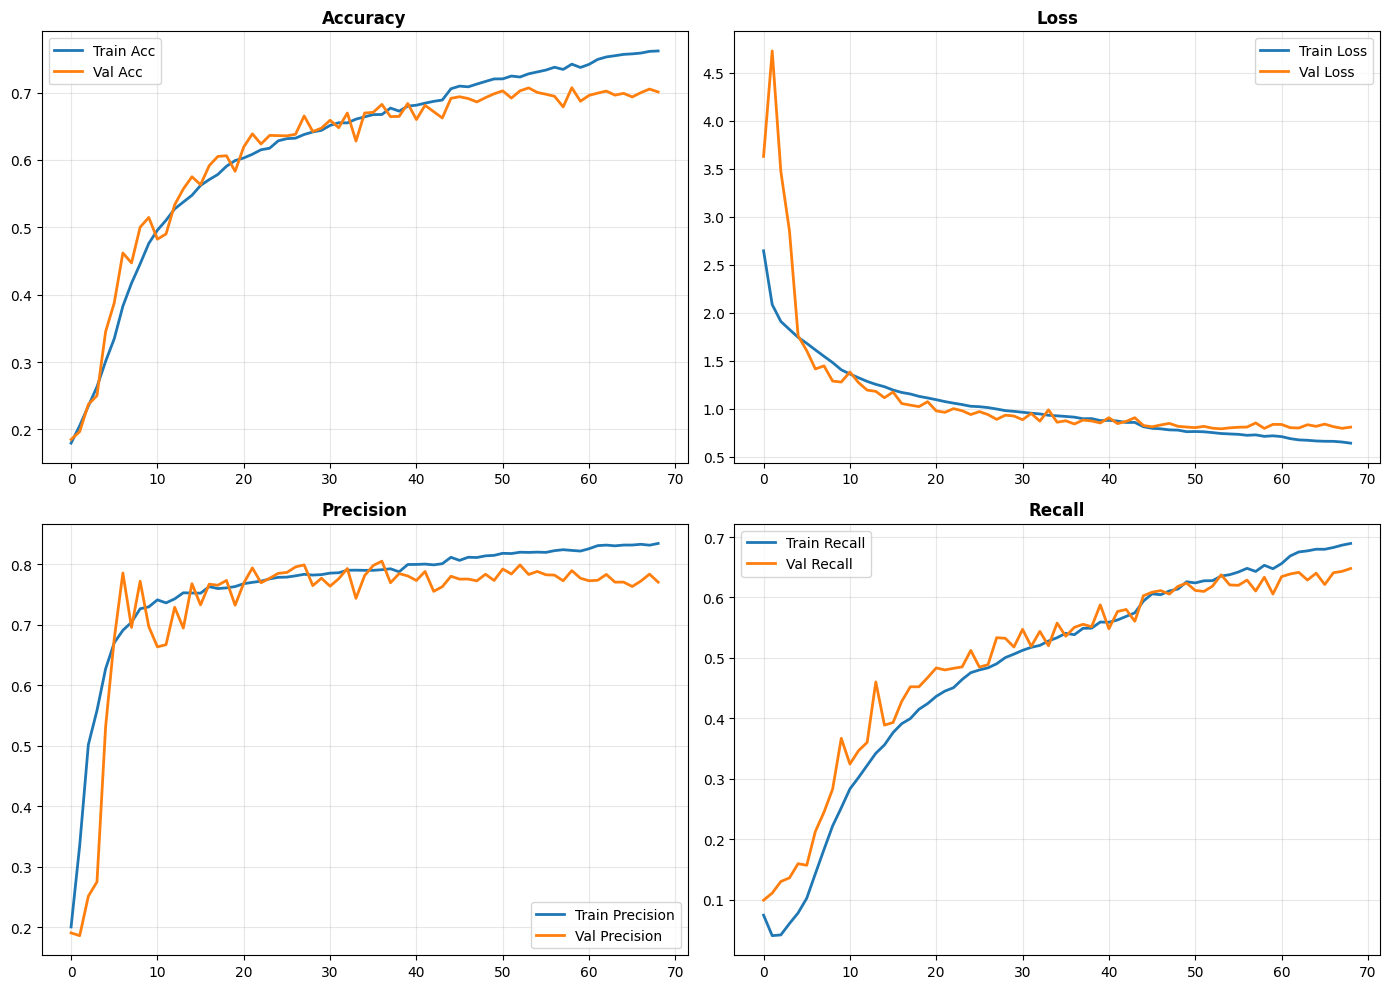


📊 Évaluation sur le test set:
26/26 [==============================] - 2s 44ms/step - loss: 0.8108 - accuracy: 0.7121 - precision: 0.7882 - recall: 0.6396
Test Loss: 0.8108
Test Accuracy: 0.7121
Test Precision: 0.7882
Test Recall: 0.6396
104/104 [==============================] - 1s 7ms/step

✅ Accuracy globale: 71.21%
104/104 [==============================] - 1s 5ms/step

📈 Métriques par émotion:
Angry        - Precision: 0.557 | Recall: 0.709 | F1: 0.624 | Support: 491
Disgust      - Precision: 0.599 | Recall: 0.608 | F1: 0.604 | Support: 393
Fear         - Precision: 0.912 | Recall: 0.843 | F1: 0.876 | Support: 733
Happy        - Precision: 0.558 | Recall: 0.428 | F1: 0.485 | Support: 425
Sad          - Precision: 0.553 | Recall: 0.529 | F1: 0.541 | Support: 452
Surprise     - Precision: 0.952 | Recall: 0.969 | F1: 0.960 | Support: 413
Neutral      - Precision: 0.770 | Recall: 0.821 | F1: 0.795 | Support: 403


In [ ]:
def plot_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    axes[0, 0].set_title('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Loss', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Precision', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Recall', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

scores = model.evaluate(X_test, y_test, batch_size=128)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")
print(f"Test Precision: {scores[2]:.4f}")
print(f"Test Recall: {scores[3]:.4f}")

emotions_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotions_dict = {i: name for i, name in enumerate(emotions_list)}

def predict_classes(model, X, y, emotions_dict):
    class_pred = model.predict(X)
    labels_pred = np.argmax(class_pred, axis=1)
    labels_true = np.argmax(y, axis=1)
    correct = labels_pred == labels_true
    pred_emotions = pd.Series(labels_pred).map(emotions_dict)
    true_emotions = pd.Series(labels_true).map(emotions_dict)
    
    return correct, pd.DataFrame({
        'Predicted_label': labels_pred,
        'Predicted_emotion': pred_emotions,
        'True_label': labels_true,
        'True_emotion': true_emotions,
        'Is_correct': correct
    })

correct, results_df = predict_classes(model, X_test, y_test, emotions_dict)

print(f"\n Accuracy globale: {correct.mean()*100:.2f}%")


y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=range(labels_count))

for i, emotion in enumerate(emotions_list):
    print(f"{emotion:12} - Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {f1[i]:.3f} | Support: {int(support[i])}")


In [ ]:
model.save("../data/cnn_emotion_detector.h5")

NameError: name 'pickle' is not defined